In [8]:

from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import time
get_ipython().magic('matplotlib inline')



def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

def import_data():
    if "data" not in os.listdir(os.getcwd()):
        # Untar directory of data if we haven't already
        tarObject = tarfile.open("data.tar.gz")
        tarObject.extractall()
        tarObject.close()
        print("Extracted tar to current directory")
    else:
        # we've already extracted the files
        pass

    print("loading training data")
    trainX = csv_to_numpy_array("data/trainX.csv", delimiter="\t")
    trainY = csv_to_numpy_array("data/trainY.csv", delimiter="\t")
    print("loading test data")
    testX = csv_to_numpy_array("data/testX.csv", delimiter="\t")
    testY = csv_to_numpy_array("data/testY.csv", delimiter="\t")
    return trainX,trainY,testX,testY

trainX,trainY,testX,testY = import_data()




/usr/lib/python3/dist-packages/matplotlib/__init__.py:1175: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


loading training data
loading test data


In [26]:
numFeatures = trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[1]

#numEpochs = 20000
numEpochs = 7080
learningRate = 0.5
print ("Num Features",numFeatures)
print ("Labels:",numLabels)

Num Features 2955
Labels: 2


In [27]:

X = tf.placeholder(tf.float32, [None, numFeatures])
yGold = tf.placeholder(tf.float32, [None, numLabels])

# Hidden Layer 1 Parameters
weights1 = tf.Variable(tf.random_normal([numFeatures,numLabels*3],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias1 = tf.Variable(tf.random_normal([1,numLabels*3],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))
# Hidden Layer 2 parameters
weights2 = tf.Variable(tf.random_normal([numLabels*3,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias2 = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))


step 0, training accuracy 0.466946
step 0, change in cost 1.86836
step 10, training accuracy 0.485834
step 10, change in cost 1.17037
step 20, training accuracy 0.485834
step 20, change in cost 0.000935495
step 30, training accuracy 0.491081
step 30, change in cost 0.000919163
step 40, training accuracy 0.49213
step 40, change in cost 0.000904024
step 50, training accuracy 0.494229
step 50, change in cost 0.000889659
step 60, training accuracy 0.496327
step 60, change in cost 0.000876427
step 70, training accuracy 0.496327
step 70, change in cost 0.000863791
step 80, training accuracy 0.497377
step 80, change in cost 0.000852764
step 90, training accuracy 0.499475
step 90, change in cost 0.000842333
step 100, training accuracy 0.499475
step 100, change in cost 0.000832379
step 110, training accuracy 0.499475
step 110, change in cost 0.000823796
step 120, training accuracy 0.502623
step 120, change in cost 0.000816047
step 130, training accuracy 0.505771
step 130, change in cost 0.00080

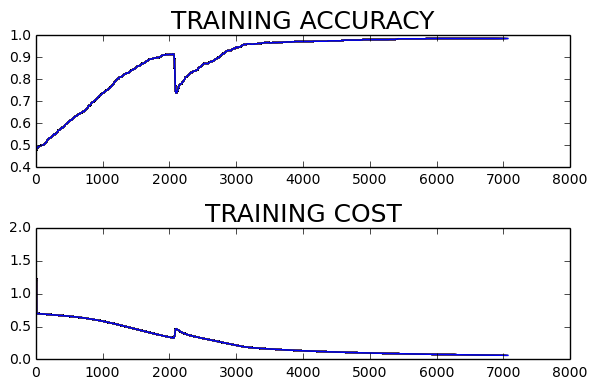

In [28]:

init_OP = tf.initialize_all_variables()

# Hidden Layer 1: Obtaining weighted matrix
apply_weights_OP = tf.matmul(X, weights1, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias1, name="add_bias") 

# Activation Funciton
activation_OP1 = tf.nn.sigmoid(add_bias_OP, name="activation")

# Hidden Layer 2
activation_OP = tf.nn.softmax(tf.add(tf.matmul(activation_OP1,weights2), bias2))


# Cross Entropy eror
#cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")
cost_OP = tf.reduce_mean(-tf.reduce_sum(yGold * tf.log(activation_OP), reduction_indices=[1]))

# Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()


# Initialize reporting variables
cost = 0
diff = 1
errors =[]
with tf.Session() as sess:
    sess.run(init_OP)
    correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
    accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
        

# Training
    for i in range(numEpochs):
        if i > 1 and diff < .0001:
            print("change in cost %g; convergence."%diff)
            break
        else:
        # Run training step
            step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
            if i % 10 == 0:
            # Add epoch to epoch_values
                epoch_values.append(i)
            # Generate accuracy stats on test data
                train_accuracy, newCost = sess.run(
                [accuracy_OP, cost_OP], 
                feed_dict={X: trainX, yGold: trainY}
                )
                #errors.append(1 - train_accuracy)
            # Add accuracy to live graphing variable
                accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
                cost_values.append(newCost)
           
            # Re-assign values for variables
                diff = abs(newCost - cost)
                cost = newCost

                print("step %d, training accuracy %g"%(i, train_accuracy))
                errors.append(1 - train_accuracy)
                #print("step %d, cost %g"%(i, newCost))
                print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
                accuracyLine, = ax1.plot(epoch_values, accuracy_values)
                costLine, = ax2.plot(epoch_values, cost_values)
                fig.canvas.draw()
                time.sleep(1)


    print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))
    print("Error: ", errors[-1])
    print('Weights and Bias values:')
    print(sess.run(weights2), " ", sess.run(bias2))
    

In [30]:
errors[:]

[0.53305351734161377,
 0.51416578888893127,
 0.51416578888893127,
 0.50891920924186707,
 0.5078698992729187,
 0.50577124953269958,
 0.50367259979248047,
 0.50367259979248047,
 0.5026232898235321,
 0.50052466988563538,
 0.50052466988563538,
 0.50052466988563538,
 0.49737668037414551,
 0.4942287802696228,
 0.49317944049835205,
 0.49003148078918457,
 0.48373556137084961,
 0.47953832149505615,
 0.47429168224334717,
 0.47114378213882446,
 0.46799582242965698,
 0.46694648265838623,
 0.46694648265838623,
 0.4648478627204895,
 0.46169990301132202,
 0.45750260353088379,
 0.45435464382171631,
 0.4491080641746521,
 0.45225602388381958,
 0.45225602388381958,
 0.4491080641746521,
 0.44596010446548462,
 0.44071352481842041,
 0.4354669451713562,
 0.43336832523345947,
 0.43231898546218872,
 0.43126964569091797,
 0.42707240581512451,
 0.42392444610595703,
 0.42077648639678955,
 0.4218258261680603,
 0.41972720623016357,
 0.41552990674972534,
 0.41238194704055786,
 0.40713536739349365,
 0.405036747455596

In [17]:
    print('Weights and Bias values:')
    print(sess.run(weights2), " ", sess.run(bias2))
    print("Error: ", errors[-1])

Weights and Bias values:
Error:  0.0146904587746


/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


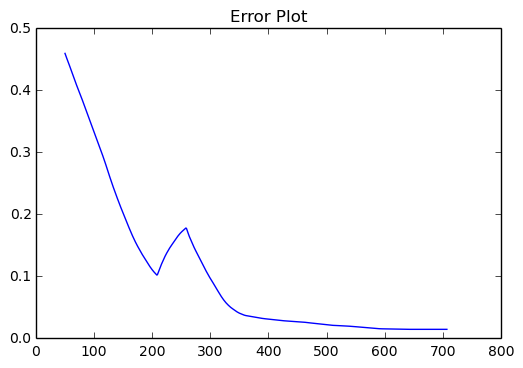

In [31]:
get_ipython().magic('matplotlib inline')
plt.title('Error Plot')
plt.plot([np.mean(errors[i-50:i]) for i in range(len(errors))])
plt.show()